# Backtesting with Zipline - Using the Pipeline API with ML-driven Signals

> This notebook requires the `conda` environment `backtest`. Please see the [installation instructions](../installation/README.md) for running the latest Docker image or alternative ways to set up your environment.

## Imports & Settings

In [1]:
!conda install -y -c quantopian ta-lib
!pip install pyfolio
# https://github.com/stefan-jansen/zipline-reloaded
!pip install zipline-reloaded
!pip install Logbook
!pip install ipython-autotime

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - ta-lib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libta-lib-0.4.0            |       h516909a_0         503 KB  conda-forge
    ta-lib-0.4.19              |   py37ha21ca33_2         407 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         910 KB

The following NEW packages will be INSTALLED:

  libta-lib          conda-forge/linux-64::libta-lib-0.4.0-h516909a_0
  ta-lib             conda-forge/linux-64::ta-lib-0.4.19-py37ha21ca33_2



ta-lib-0.4.19        | 407 KB    | ##################################### | 100% 
lib

In [2]:
# modify create_full_tear_sheet of alphalens
# src: https://github.com/quantopian/alphalens/issues/379#issuecomment-654558947
#!sed -i 's/get_values/to_numpy/g' /opt/conda/lib/python3.7/site-packages/alphalens/tears.py

# modify timeseries.py of pyfolio
# src: https://github.com/quantopian/pyfolio/pull/634
!sed -i 's/valley = np.argmin(underwater)/valley = underwater.idxmin()/g' /opt/conda/lib/python3.7/site-packages/pyfolio/timeseries.py
!sed -i 's/if (len(returns) == 0) or (len(underwater) == 0):/if (len(returns) == 0) or (len(underwater) == 0) or np.min(underwater) == 0:/g' /opt/conda/lib/python3.7/site-packages/pyfolio/timeseries.py

In [3]:
### set path
import os
from pathlib import Path

path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
path_result = path_home / 'result'

In [4]:
### zipline path
import os, sys

zipline_root = path_home / 'zipline'
os.environ['ZIPLINE_ROOT'] = str(zipline_root)
sys.path.append(zipline_root.expanduser().as_posix())

custom_data_path = zipline_root / 'custom_data'
if not custom_data_path.exists():
    custom_data_path.mkdir()

In [5]:
%matplotlib inline
%load_ext autotime

from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission,
                         get_open_orders, cancel_order,
                         order_target, order_target_percent)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import JP_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

import warnings
warnings.filterwarnings('ignore')

idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

time: 2.15 s (started: 2021-05-02 06:49:24 +00:00)


In [8]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip .
!unzip stooq_jp_data.zip

!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_result.zip .
!unzip stooq_jp_result.zip

In [6]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_zipline.zip .
!unzip stooq_jp_zipline.zip

Copying gs://finance_data_bucket/lbk/rf/stooq_jp_zipline.zip...
- [1 files][219.8 MiB/219.8 MiB]                                                
Operation completed over 1 objects/219.8 MiB.                                    
Archive:  stooq_jp_zipline.zip
   creating: zipline/custom_data/.ipynb_checkpoints/
  inflating: zipline/custom_data/.ipynb_checkpoints/stooq_jp_sid_equities-checkpoint.csv  
 extracting: zipline/custom_data/.ipynb_checkpoints/stooq_jp_splits-checkpoint.csv  
  inflating: zipline/custom_data/stooq_jp_sid_prices.pickle  
  inflating: zipline/custom_data/stooq_jp_tse_stocks_tickers.csv  
  inflating: zipline/custom_data/stooq_jp_tse_stocks_prices.csv  
 extracting: zipline/custom_data/stooq_jp_splits.csv  
  inflating: zipline/custom_data/stooq_jp_sid_equities.csv  
   creating: zipline/data/
   creating: zipline/data/.ipynb_checkpoints/
   creating: zipline/data/stooq/
   creating: zipline/data/stooq/2021-04-29T11;17;32.867406/
   creating: zipline/data/stooq/2021

In [10]:
!ln -s ../../data/stooq_jp_tse_stocks_prices.csv zipline/custom_data/.
!ln -s ../../data/stooq_jp_tse_stocks_tickers.csv zipline/custom_data/.

ln: failed to create symbolic link 'zipline/custom_data/./stooq_jp_tse_stocks_prices.csv': File exists
ln: failed to create symbolic link 'zipline/custom_data/./stooq_jp_tse_stocks_tickers.csv': File exists
time: 273 ms (started: 2021-05-01 13:37:41 +00:00)


### Load zipline extensions

Only need this in notebook to find bundle.

In [7]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

time: 5.93 ms (started: 2021-05-02 06:49:39 +00:00)


In [8]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

time: 637 µs (started: 2021-05-02 06:49:39 +00:00)


## Algo Params

The strategy will hold the 25 stocks with the highest positive and lowest negative predictions each as long as there are at least 15 on each side.

In [9]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 15

time: 625 µs (started: 2021-05-02 06:49:39 +00:00)


## Load Data

In [33]:
# stooq data periods must cover prediction periods (see load_predictions).
# value error might occur if stooq periods shorter than prediction when running run_algorithm
import stooq_preprocessing
stooq_preprocessing.load('2016', '2019')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2934978 entries, ('1301.JP', Timestamp('2016-01-04 00:00:00+0000', tz='UTC')) to ('9997.JP', Timestamp('2019-12-30 00:00:00+0000', tz='UTC'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2934978 non-null  float64
 1   high    2934978 non-null  float64
 2   low     2934978 non-null  float64
 3   close   2934978 non-null  float64
 4   volume  2934978 non-null  float64
dtypes: float64(5)
memory usage: 123.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sid     3001 non-null   int64 
 1   ticker  3001 non-null   object
 2   name    3001 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.5+ KB
None
time: 33.4 s (started: 2021-04-29 11:16:49 +00:00)


In [34]:
!zipline ingest -b stooq

[2021-04-29 11:17:33.465864] INFO: zipline.data.bundles.core: Ingesting stooq.
Merging daily equity files:  [####################################]      
time: 51min 25s (started: 2021-04-29 11:17:30 +00:00)


In [12]:
bundle_data = bundles.load('stooq')

time: 404 ms (started: 2021-05-02 06:49:56 +00:00)


### ML Predictions

We generate the `train` predictions in the notebook `alphalens_signal_quality` and the `test` predictions in the notebook `random_forest_return_signals`.

In [13]:
# prediction (test_*.csv) has both of training & test periods
# which is shown in return plots

def load_predictions(bundle, positions=5):
    """
    positions: num of top positions to use
    """
    t = 1
    df = (pd.read_csv(path_result / f'test_{t:02}.csv', parse_dates=['date'])
            .set_index(['ticker','date'])
            .sort_index(level=['ticker','date'])      
         )
    df = df[~df.index.duplicated()].drop('y_test', axis=1)
    predictions = df.iloc[:, :positions].mean(1).to_frame('predictions')

    tickers = predictions.index.get_level_values('ticker').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .predictions
            .tz_localize('UTC')), assets

# predictions: daily prediction of tickers' sid
# assets: mapping ticker to sid
predictions, assets = load_predictions(bundle_data)
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2016-12-14 00:00:00+00:00 to 2018-12-28 00:00:00+00:00
Columns: 941 entries, 1 to 2994
dtypes: float64(941)
memory usage: 3.6 MB
time: 4.73 s (started: 2021-05-02 06:50:00 +00:00)


### Define Custom Dataset

In [14]:
# see for domain
# https://github.com/quantopian/zipline/blob/master/zipline/pipeline/domain.py

class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = JP_EQUITIES

time: 918 µs (started: 2021-05-02 06:50:05 +00:00)


### Define Pipeline Loaders

In [15]:
signal_loader = {SignalData.predictions:
                 DataFrameLoader(SignalData.predictions, predictions)}

time: 7.03 ms (started: 2021-05-02 06:50:05 +00:00)


## Pipeline Setup

### Custom ML Factor

In [16]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, preds):
        out[:] = preds

time: 807 µs (started: 2021-05-02 06:50:08 +00:00)


### Create Pipeline

In [17]:
def compute_signals():
    signals = MLSignal()
    predictions = SignalData.predictions.latest
    return Pipeline(columns={
        'longs': signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
        screen=StaticAssets(assets)
    )

time: 619 µs (started: 2021-05-02 06:50:10 +00:00)


## Initialize Algorithm

In [18]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()

    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.05, min_trade_cost=1))

    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

time: 968 µs (started: 2021-05-02 06:50:11 +00:00)


### Get daily Pipeline results

In [19]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    context.trades = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1))
                      .reset_index()
                      .drop_duplicates()
                      .set_index('index')
                      .squeeze())

time: 570 µs (started: 2021-05-02 06:50:14 +00:00)


## Define Rebalancing Logic

In [20]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)

    positions = context.portfolio.positions
    s = (pd.Series({s: v.amount*v.last_sale_price for s,
                    v in positions.items()})
         .sort_values(ascending=False))
    
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)

    context.longs, context.shorts = len(trades[1]), len(trades[-1])
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)

time: 1.15 ms (started: 2021-05-02 06:50:16 +00:00)


## Record Data Points

In [21]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

time: 529 µs (started: 2021-05-02 06:50:17 +00:00)


## Run Algorithm

In [22]:
dates = predictions.index.get_level_values('date')
start_date = dates.min() + pd.DateOffset(day=1)
end_date = dates.max()
print('Start:\t{}\nEnd:\t{}'.format(start_date.date(), end_date.date()))

Start:	2016-12-01
End:	2018-12-28
time: 2.55 ms (started: 2021-05-02 06:50:19 +00:00)


In [23]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e6,
                        data_frequency='daily',
                        bundle='stooq',
                        custom_loader=signal_loader)

print('Duration: {:.2f}s'.format(time() - start))

[2021-05-02 06:51:26.577157]: INFO: handle_simulation_end: Simulated 522 trading days
first open: 2016-12-01 14:31:00+00:00
last close: 2018-12-28 21:00:00+00:00


Duration: 64.83s
time: 1min 4s (started: 2021-05-02 06:50:21 +00:00)


In [24]:
index=-1
index=-22

time: 532 µs (started: 2021-05-02 07:08:27 +00:00)


In [64]:
results.iloc[index]

period_open                                        2019-11-27 14:31:00+00:00
period_close                                       2019-11-27 21:00:00+00:00
long_exposure                                                      140092.44
orders                     [{'id': 'c6316e0ccb4d4c36bba3734511084535', 'd...
transactions               [{'amount': -10, 'dt': 2019-11-27 21:00:00+00:...
positions                  [{'sid': Equity(530 [3105.JP]), 'amount': 38, ...
short_exposure                                                           0.0
starting_exposure                                                    -1625.1
gross_leverage                                                      0.154995
ending_exposure                                                    140092.44
starting_value                                                       -1625.1
net_leverage                                                        0.154995
ending_value                                                       140092.44

time: 39.5 ms (started: 2021-05-01 06:26:09 +00:00)


In [65]:
# TODO: make compact
results.iloc[index].orders

[{'id': 'c6316e0ccb4d4c36bba3734511084535',
  'dt': Timestamp('2019-11-27 21:00:00+0000', tz='UTC'),
  'reason': None,
  'created': Timestamp('2019-11-26 21:00:00+0000', tz='UTC'),
  'amount': -10,
  'filled': -10,
  'commission': 1,
  'stop': None,
  'limit': None,
  'stop_reached': False,
  'limit_reached': False,
  'sid': Equity(5 [1377.JP]),
  'status': 1},
 {'id': 'dcfdf60056a04efda7c8df4b9fae1319',
  'dt': Timestamp('2019-11-27 21:00:00+0000', tz='UTC'),
  'reason': None,
  'created': Timestamp('2019-11-26 21:00:00+0000', tz='UTC'),
  'amount': -17,
  'filled': -17,
  'commission': 1,
  'stop': None,
  'limit': None,
  'stop_reached': False,
  'limit_reached': False,
  'sid': Equity(350 [2613.JP]),
  'status': 1},
 {'id': '0e9ec39d5b1d4a31a6170d80394d639b',
  'dt': Timestamp('2019-11-27 21:00:00+0000', tz='UTC'),
  'reason': None,
  'created': Timestamp('2019-11-26 21:00:00+0000', tz='UTC'),
  'amount': -7,
  'filled': -7,
  'commission': 1,
  'stop': None,
  'limit': None,
  'st

time: 29 ms (started: 2021-05-01 06:26:13 +00:00)


In [66]:
results.iloc[index].transactions

[{'amount': -10,
  'dt': Timestamp('2019-11-27 21:00:00+0000', tz='UTC'),
  'price': 3482.57,
  'order_id': 'c6316e0ccb4d4c36bba3734511084535',
  'sid': Equity(5 [1377.JP]),
  'commission': None},
 {'amount': -17,
  'dt': Timestamp('2019-11-27 21:00:00+0000', tz='UTC'),
  'price': 2070.25,
  'order_id': 'dcfdf60056a04efda7c8df4b9fae1319',
  'sid': Equity(350 [2613.JP]),
  'commission': None},
 {'amount': -7,
  'dt': Timestamp('2019-11-27 21:00:00+0000', tz='UTC'),
  'price': 4945.78,
  'order_id': '0e9ec39d5b1d4a31a6170d80394d639b',
  'sid': Equity(356 [2659.JP]),
  'commission': None},
 {'amount': 27,
  'dt': Timestamp('2019-11-27 21:00:00+0000', tz='UTC'),
  'price': 1338.83,
  'order_id': 'd6d3482afad04d288e8716a7eede45b8',
  'sid': Equity(421 [2792.JP]),
  'commission': None},
 {'amount': -24,
  'dt': Timestamp('2019-11-27 21:00:00+0000', tz='UTC'),
  'price': 1470.43,
  'order_id': '4b26e913c2b6416b91169ef40183e51f',
  'sid': Equity(458 [2910.JP]),
  'commission': None},
 {'amount

time: 19.8 ms (started: 2021-05-01 06:27:50 +00:00)


## PyFolio Analysis

In [25]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

time: 1.19 s (started: 2021-05-02 07:08:30 +00:00)


In [32]:
transactions.loc['2018-12-28']

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2018-12-28 21:00:00+00:00,Equity(2807 [9504.JP]),Equity(2807 [9504.JP]),1355.66,77e09d18e4ef48319e50c27e4e44d479,-30,None,2018-12-28 21:00:00+00:00,40669.80
2018-12-28 21:00:00+00:00,Equity(2807 [9504.JP]),Equity(2807 [9504.JP]),1355.66,5eed70170e7645188559a62366ac932b,-60,None,2018-12-28 21:00:00+00:00,81339.60
2018-12-28 21:00:00+00:00,Equity(190 [2175.JP]),Equity(190 [2175.JP]),1716.19,51afeb03c80f4823b99b0360e9b0b45a,-23,None,2018-12-28 21:00:00+00:00,39472.37
2018-12-28 21:00:00+00:00,Equity(223 [2269.JP]),Equity(223 [2269.JP]),8572.17,c19efbede55c466db6c3e7dc475d0b70,-4,None,2018-12-28 21:00:00+00:00,34288.68
2018-12-28 21:00:00+00:00,Equity(342 [2593.JP]),Equity(342 [2593.JP]),4858.17,1b01edb926d14264899dce7dfe459bf9,-8,None,2018-12-28 21:00:00+00:00,38865.36
2018-12-28 21:00:00+00:00,Equity(362 [2670.JP]),Equity(362 [2670.JP]),5720.83,30f87e85b3444d1f94e14c7e9c94bfdc,-7,None,2018-12-28 21:00:00+00:00,40045.81
2018-12-28 21:00:00+00:00,Equity(642 [3333.JP]),Equity(642 [3333.JP]),1323.44,2aa78b0022464c0c8b83e97ac31eec12,-30,None,2018-12-28 21:00:00+00:00,39703.20
2018-12-28 21:00:00+00:00,Equity(661 [3382.JP]),Equity(661 [3382.JP]),4502.08,342f43829179424d8c48820d7a8a1bbf,-9,None,2018-12-28 21:00:00+00:00,40518.72
2018-12-28 21:00:00+00:00,Equity(1041 [4452.JP]),Equity(1041 [4452.JP]),7897.95,7bd541bb20084f9f9b069b5526df6b19,-5,None,2018-12-28 21:00:00+00:00,39489.75
2018-12-28 21:00:00+00:00,Equity(1110 [4612.JP]),Equity(1110 [4612.JP]),743.49,56efc789a05c48acbf10d003f4c198ec,-55,None,2018-12-28 21:00:00+00:00,40891.95


time: 33.4 ms (started: 2021-05-02 07:11:44 +00:00)


In [31]:
positions.iloc[-1].loc[positions.iloc[-1].gt(0)]

sid
Equity(97 [1885.JP])        42221.540
Equity(529 [3104.JP])       38916.060
Equity(691 [3436.JP])       41669.950
Equity(729 [3626.JP])       41724.300
Equity(941 [4109.JP])       39348.480
Equity(1073 [4548.JP])      40723.500
Equity(1208 [4813.JP])      42461.280
Equity(1298 [5186.JP])      40253.200
Equity(1300 [5191.JP])      42924.490
Equity(1354 [5406.JP])      42280.560
Equity(1357 [5411.JP])      42157.750
Equity(1376 [5541.JP])      40953.600
Equity(1556 [6145.JP])      43295.120
Equity(1644 [6324.JP])      41697.740
Equity(1742 [6481.JP])      41036.200
Equity(1779 [6622.JP])      42147.800
Equity(1792 [6641.JP])      41860.560
Equity(1809 [6674.JP])      40303.560
Equity(1863 [6794.JP])      41928.460
Equity(2025 [7238.JP])      42273.000
Equity(2031 [7245.JP])      42032.600
Equity(2055 [7287.JP])      42554.160
Equity(2187 [7701.JP])      40404.450
Equity(2548 [8473.JP])      41021.000
Equity(2614 [8795.JP])      41838.840
cash                      1061020.824
Name: 20

time: 6.85 ms (started: 2021-05-02 07:11:09 +00:00)


In [33]:
returns

2016-12-01 00:00:00+00:00    0.000000
2016-12-02 00:00:00+00:00    0.000000
2016-12-05 00:00:00+00:00    0.000000
2016-12-06 00:00:00+00:00    0.000000
2016-12-07 00:00:00+00:00    0.000000
                               ...   
2018-12-21 00:00:00+00:00   -0.000208
2018-12-24 00:00:00+00:00    0.000000
2018-12-26 00:00:00+00:00   -0.005101
2018-12-27 00:00:00+00:00    0.009665
2018-12-28 00:00:00+00:00   -0.000621
Name: returns, Length: 522, dtype: float64

time: 5.06 ms (started: 2021-05-02 07:13:08 +00:00)


In [34]:
benchmark = web.DataReader('NIKKEI225', 
                           'fred', 
                           start='2016', 
                           end='2020').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

time: 408 ms (started: 2021-05-02 07:13:22 +00:00)


### Custom Plots

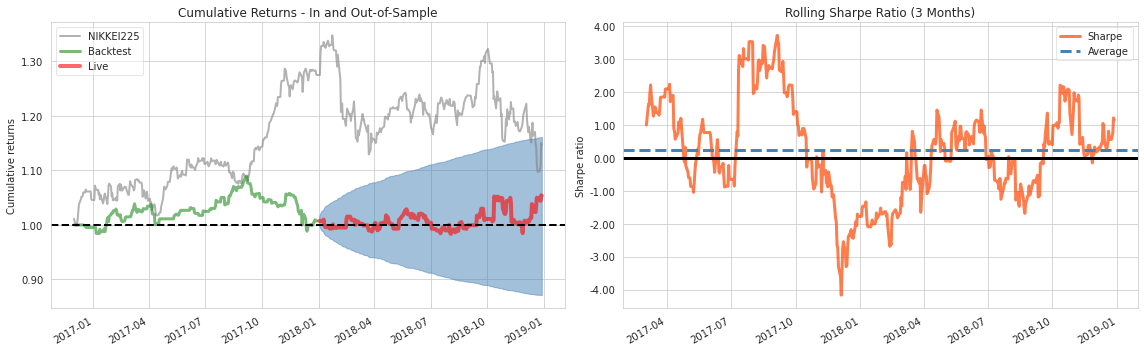

time: 1.84 s (started: 2021-05-02 07:13:24 +00:00)


In [35]:
# see prediction data for backtest and live periods
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date='2018-01-01',
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()
fig.savefig((path_result / 'pyfolio_out_of_sample').as_posix(), dpi=300);

### Tear Sheets

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.70,2017-09-06,2018-08-03,NaT,NaN
1,3.70,2017-03-09,2017-04-12,2017-07-19,95
2,2.23,2017-02-07,2017-02-17,2017-03-08,22
3,1.55,2016-12-15,2017-01-11,2017-01-23,28
4,1.32,2017-07-31,2017-08-02,2017-08-09,8


Stress Events,mean,min,max
New Normal,0.01%,-3.46%,4.26%


Top 10 long positions of all time,max
sid,
3333.JP,11.21%
9861.JP,11.10%
4331.JP,11.02%
8841.JP,9.67%
1861.JP,9.35%
6736.JP,9.26%
8107.JP,9.22%
9076.JP,8.84%
8029.JP,8.79%


Top 10 short positions of all time,max
sid,
8841.JP,-13.42%
1861.JP,-13.00%
4921.JP,-12.45%
3097.JP,-11.44%
5563.JP,-10.43%
4849.JP,-8.51%
4996.JP,-8.38%
7593.JP,-8.13%
8107.JP,-8.13%


Top 10 positions of all time,max
sid,
8841.JP,13.42%
1861.JP,13.00%
4921.JP,12.45%
3097.JP,11.44%
3333.JP,11.21%
9861.JP,11.10%
4331.JP,11.02%
5563.JP,10.43%
6736.JP,9.26%


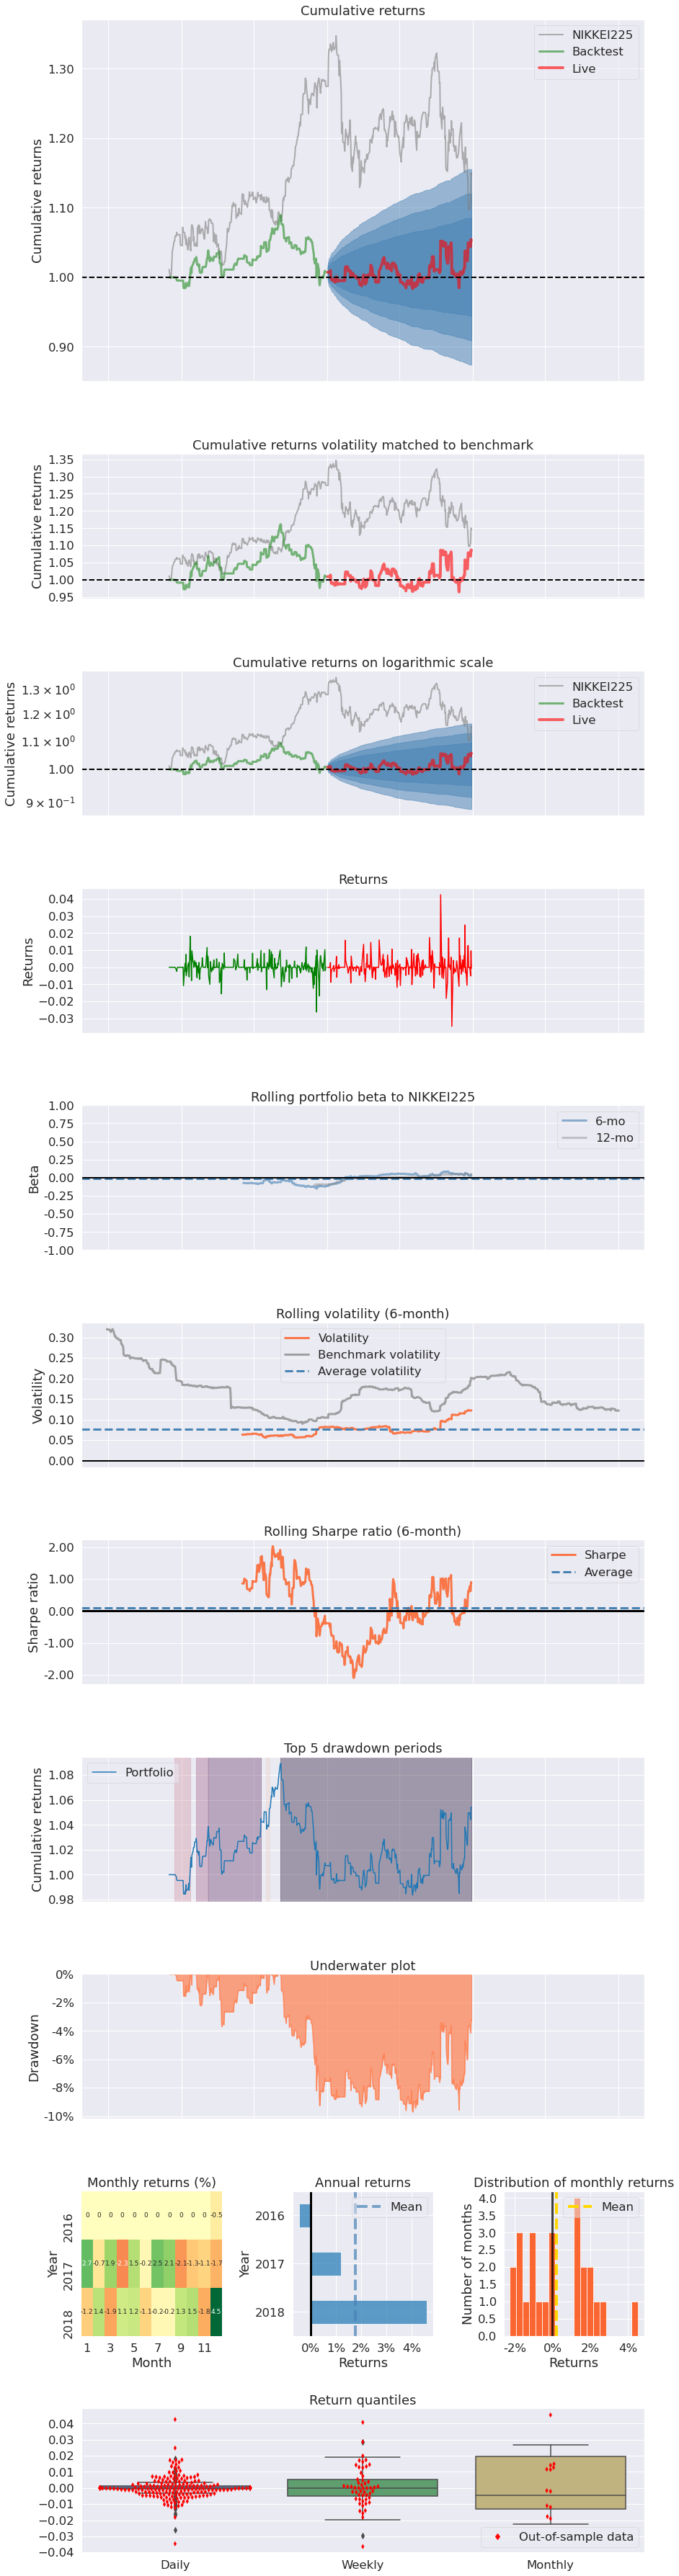

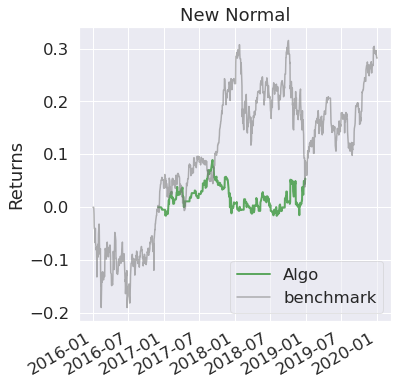

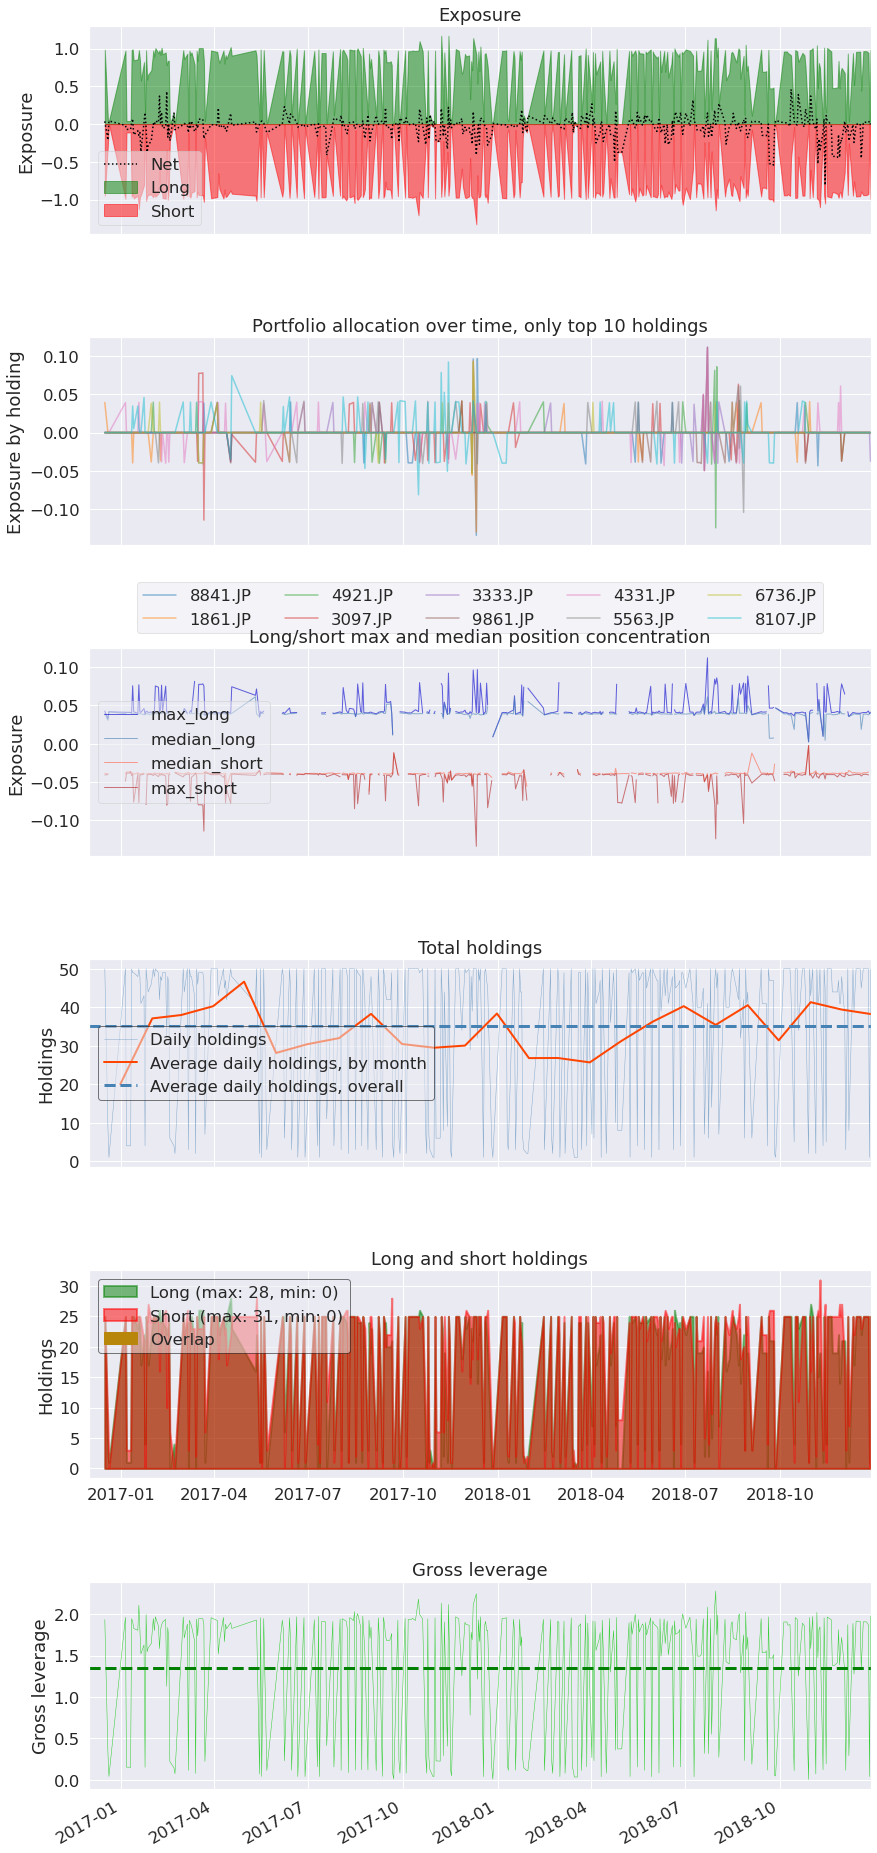

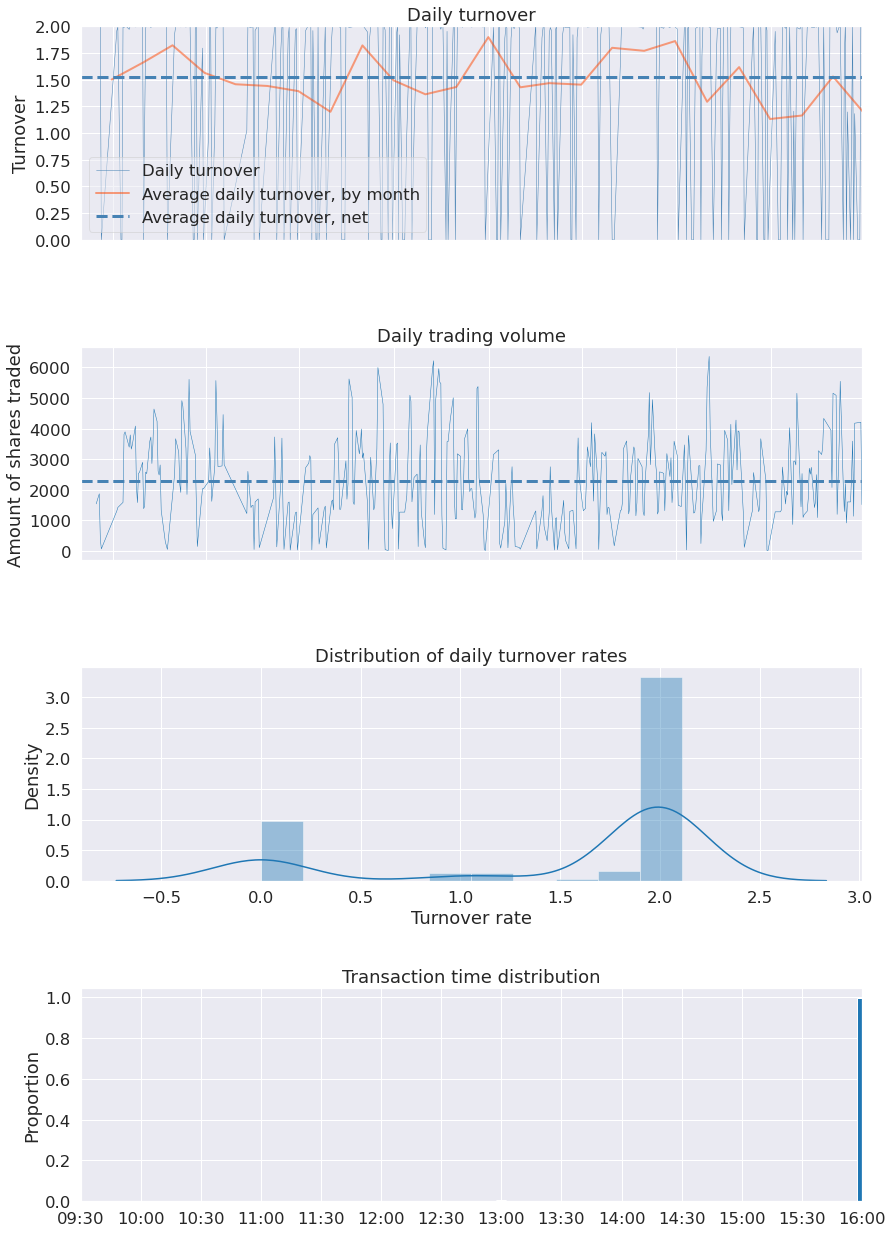

time: 15.6 s (started: 2021-04-29 13:19:08 +00:00)


In [72]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2018-01-01', 
                          #round_trips=True # TODO: ERROR
                         ) 

In [ ]:
!zip -r stooq_jp_zipline.zip zipline/custom_data zipline/data
!gsutil cp stooq_jp_zipline.zip gs://finance_data_bucket/lbk/rf/
!gsutil ls -l gs://finance_data_bucket/lbk/rf